## ***Failed try***
***tensorfelow and cunda version***

When we attempted to use the model and observe the results, we encountered errors such as:

(No DNN in stream executor.
[[{{node sequential_1_1/conv2d_2_1/Relu}}]]
[Op:__inference_one_step_on_data_distributed_1112])

After investigating, we discovered that the updated version of TensorFlow was not properly connected to CUDA during training. However, by switching to TensorFlow version 1.15, we were able to resolve this error and successfully train the model.

***Overfitting Issues***

Upon training our model, we noticed signs of overfitting. Specifically, the accuracy and loss on the validation dataset were consistently better than those on the training dataset, even during the first epoch. Despite trying various approaches like data augmentation and the use of dropout layers, the results were still unsatisfactory. After experimenting with several techniques, we ultimately decided to switch our character recognition model to YOLO, as it provided more promising results


In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tf_keras


In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import glob
from PIL import Image
#from ultralytics import YOLO
import urllib.request
from google.colab.patches import cv2_imsho
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Lambda, Reshape, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Permute, TimeDistributed
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
# #Load the vehicles training dataset
# !gdown 1pe4_HgXb9dctFGJXVNlyNcKSXZeht0lX
# !unzip car_img-test.zip -d car_train

In [ ]:
# # # Load the vehicles validation dataset
# !gdown 1hwz6X-Zp7JpJL35K6P3z7k6O_PTXhUcT
# !unzip car_img-validation.zip -d car_validation

In [ ]:
# # # Load the license plates training dataset
# !gdown 1PBbW1I7Itdf83bH_p60vo3_jrGTS0yLM
# !unzip plate_image_with_dummy-train.zip -d plate_train

In [ ]:
!pip install tensorflow==2.15

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/plate_image_with_dummy-train.zip' -d plate_train

Streaming output truncated to the last 5000 lines.
  inflating: plate_train/train/dummy_te_14501.jpg  
  inflating: plate_train/train/dummy_te_14501.xml  
  inflating: plate_train/train/dummy_te_14502.jpg  
  inflating: plate_train/train/dummy_te_14502.xml  
  inflating: plate_train/train/dummy_te_14503.jpg  
  inflating: plate_train/train/dummy_te_14503.xml  
  inflating: plate_train/train/dummy_te_14504.jpg  
  inflating: plate_train/train/dummy_te_14504.xml  
  inflating: plate_train/train/dummy_te_14505.jpg  
  inflating: plate_train/train/dummy_te_14505.xml  
  inflating: plate_train/train/dummy_te_14506.jpg  
  inflating: plate_train/train/dummy_te_14506.xml  
  inflating: plate_train/train/dummy_te_14507.jpg  
  inflating: plate_train/train/dummy_te_14507.xml  
  inflating: plate_train/train/dummy_te_14508.jpg  
  inflating: plate_train/train/dummy_te_14508.xml  
  inflating: plate_train/train/dummy_te_14509.jpg  
  inflating: plate_train/train/dummy_te_14509.xml  
  inflating: 

In [ ]:
def folder_organizer(folder_path):
    # Define target directory
    images_dir = os.path.join(folder_path, "images")
    labels_dir = os.path.join(folder_path, "labels")

    # Create folders if don't exist
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for file_name in os.listdir(folder_path):
        if file_name in ("images", "labels"):
            continue

        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            lower_name = file_name.lower()
            if lower_name.endswith(('.jpg')):
                try:
                    shutil.move(file_path, os.path.join(images_dir, file_name))
                except Exception as e:
                    print(f"Image transfer error {file_name}: {e}")
            elif lower_name.endswith('.xml'):
                try:
                    shutil.move(file_path, os.path.join(labels_dir, file_name))
                except Exception as e:
                    print(f"XML transfer error {file_name}: {e}")

    print(f'✅ The organization successfully done at "{folder_path}".')

folder_organizer('/content/plate_train/train')

✅ The organization successfully done at "/content/car_train/test".
✅ The organization successfully done at "/content/car_validation/validation".
✅ The organization successfully done at "/content/plate_train/train".


In [ ]:
def count_files(folder):
    print(f"📂 {folder}:")
    print(" images:", len(os.listdir(os.path.join(folder, "images"))))
    print(" labels:", len(os.listdir(os.path.join(folder, "labels"))))

count_files('/content/plate_train/train')

📂 /content/car_train/test:
 images: 4176
 labels: 4176
📂 /content/car_validation/validation:
 images: 2120
 labels: 2120
📂 /content/plate_train/train:
 images: 45469
 labels: 45469


In [ ]:
import os

#path = "/content/plate_train/train/images"
path = "/content/plate_train/train/labels"

files = os.listdir(path)

print("path =/content/plate_train/train/labels", files[:10])

path =/content/plate_train/train/labels ['08651.xml', '18998.xml', '14824.xml', 'dummy_alef_12465.xml', 'dummy_base_5013.xml', 'dummy_pe_13504.xml', '00327.xml', 'dummy_base_4430.xml', 'dummy_base_11841.xml', 'dummy_se_15609.xml']


In [ ]:
classes = {'کل ناحیه پلاک': 0}

def update_classes(folder_path):
    global classes
    labels_dir = os.path.join(folder_path, "labels")

    for xml_file in os.listdir(labels_dir):
        xml_path = os.path.join(labels_dir, xml_file)
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()

            for obj in root.findall('.//object'):
                name = obj.find('name').text
                if name not in classes:
                    new_id = len(classes)
                    classes[name] = new_id
        except ET.ParseError as e:
            print(f"Error parsing {xml_file}: {e}")
            continue

# all datasets
datasets = [
    '/content/plate_train/train'
]

for dataset in datasets:
    update_classes(dataset)

print("\nFinal class mapping:")
for class_name, class_id in sorted(classes.items(), key=lambda x: x[1]):
    print(f"Class: {class_name}, ID: {class_id}")


Final class mapping:
Class: کل ناحیه پلاک, ID: 0
Class: 6, ID: 1
Class: 5, ID: 2
Class: ه‍, ID: 3
Class: 2, ID: 4
Class: 1, ID: 5
Class: 8, ID: 6
Class: د, ID: 7
Class: 7, ID: 8
Class: 9, ID: 9
Class: ق, ID: 10
Class: 3, ID: 11
Class: 4, ID: 12
Class: ج, ID: 13
Class: ل, ID: 14
Class: 0, ID: 15
Class: ن, ID: 16
Class: م, ID: 17
Class: س, ID: 18
Class: و, ID: 19
Class: ص, ID: 20
Class: ع, ID: 21
Class: ی, ID: 22
Class: ت, ID: 23
Class: ب, ID: 24
Class: ط, ID: 25
Class: ژ (معلولین و جانبازان), ID: 26
Class: الف, ID: 27
Class: پ, ID: 28
Class: ث, ID: 29
Class: ظ, ID: 30
Class: ش, ID: 31
Class: ف, ID: 32
Class: گ, ID: 33
Class: S, ID: 34
Class: D, ID: 35
Class: ه, ID: 36
Class: تشریفات, ID: 37
Class: ک, ID: 38
Class: ز, ID: 39


In [ ]:
def convert_xml_to_txt(folder_path):
    labels_dir = os.path.join(folder_path, "labels")
    images_dir = os.path.join(folder_path, "images")

    for xml_file in os.listdir(labels_dir):
        if not xml_file.endswith('.xml'):
            continue

        xml_path = os.path.join(labels_dir, xml_file)
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()

            img_file = xml_file.replace('.xml', '.jpg')
            img_path = os.path.join(images_dir, img_file)
            img = cv2.imread(img_path)


            img_height, img_width = img.shape[:2]
            txt_lines = []

            for obj in root.findall('.//object'):
                name = obj.find('name').text
                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)

                # Normalization process
                x_center = ((xmin + xmax) / 2) / img_width
                y_center = ((ymin + ymax) / 2) / img_height
                width = (xmax - xmin) / img_width
                height = (ymax - ymin) / img_height

                class_id = classes[name]
                txt_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

            # Saving
            txt_path = os.path.join(labels_dir, xml_file.replace('.xml', '.txt'))
            with open(txt_path, 'w', encoding='utf-8') as f:
                f.write('\n'.join(txt_lines))
            # Delete XML files
            os.remove(xml_path)
        except Exception as e:
            print(f"Error processing {xml_file}: {e}")
            continue
    print(f'✅ Converting process on "{folder_path}" dataset successfully done.')


# Convert all XML files to TXT
for dataset in datasets:
    convert_xml_to_txt(dataset)

✅ Converting process on "/content/car_train/test" dataset successfully done.
✅ Converting process on "/content/car_validation/validation" dataset successfully done.
✅ Converting process on "/content/plate_train/train" dataset successfully done.


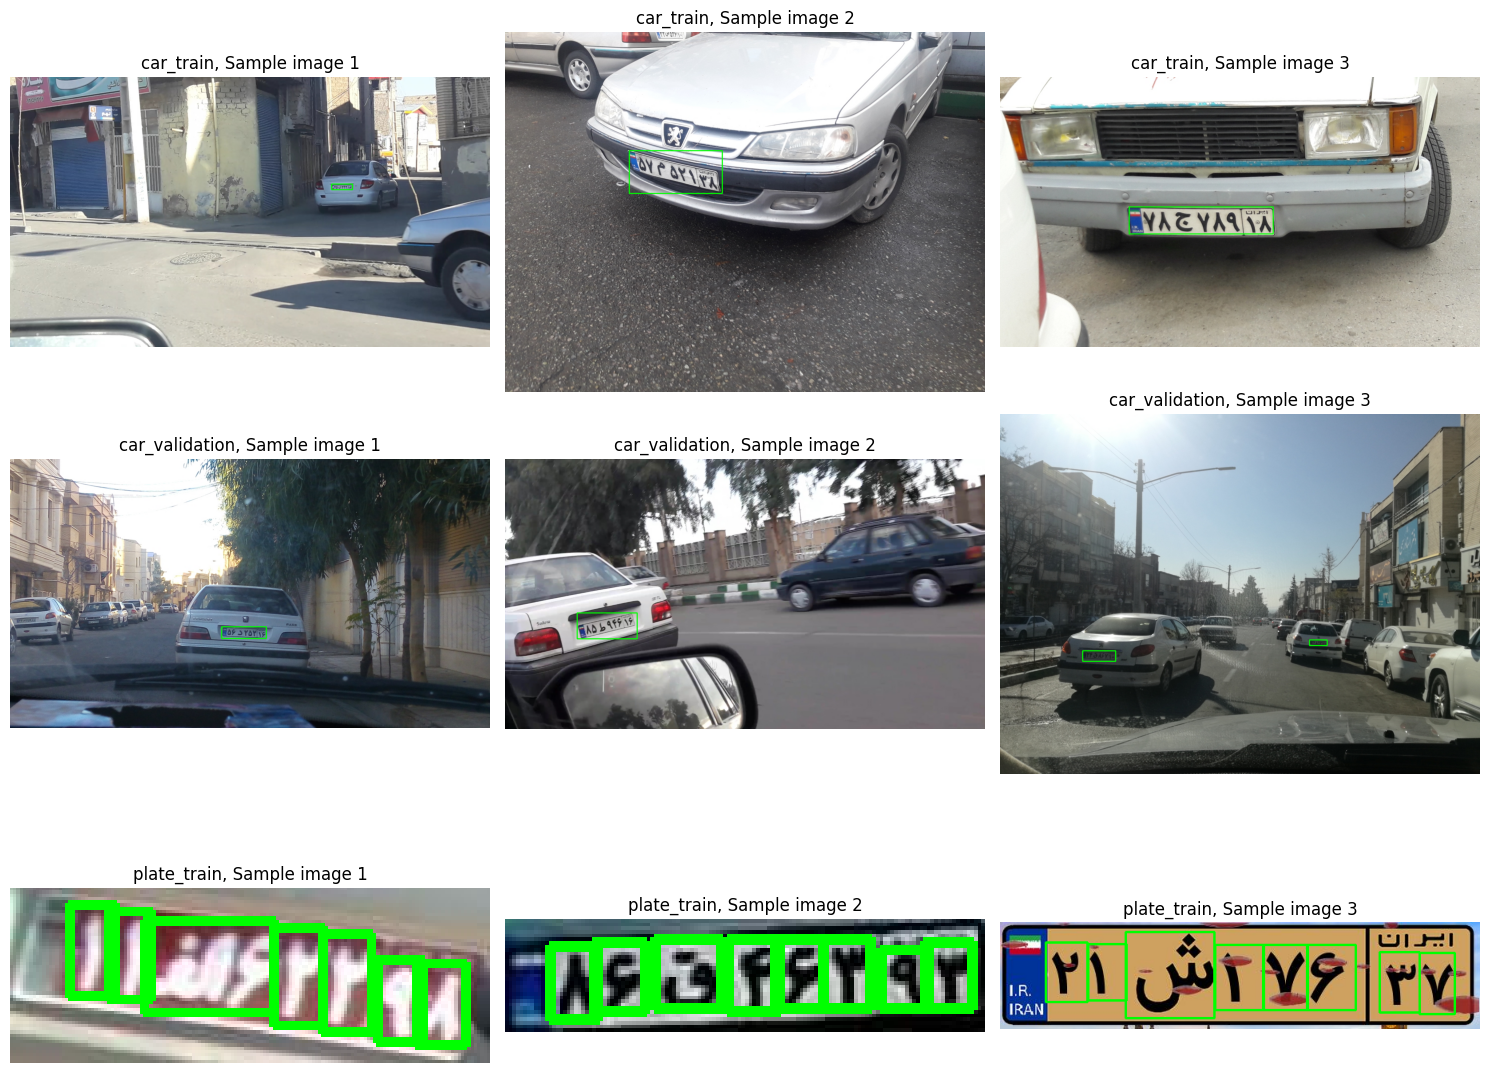

In [ ]:
def visualize_datasets(dataset_paths):
    plt.figure(figsize=(15, 12))
    for dataset_idx, dataset_path in enumerate(dataset_paths):
        images_dir = os.path.join(dataset_path, 'images')
        labels_dir = os.path.join(dataset_path, 'labels')
        # Get folder name from path
        folder_name = os.path.basename(os.path.dirname(dataset_path))

        # Selecting random image to display
        image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg'))]
        if len(image_files) >= 3:
            selected_images = random.sample(image_files, 3)

            for img_idx, img_file in enumerate(selected_images):
                img_path = os.path.join(images_dir, img_file)
                img = cv2.imread(img_path)
                img_height, img_width = img.shape[:2]
                label_file = os.path.splitext(img_file)[0] + '.txt'
                label_path = os.path.join(labels_dir, label_file)

                if os.path.exists(label_path):
                    with open(label_path, 'r') as f:
                        for line in f.readlines():
                            class_id, x_center, y_center, width, height = map(float, line.strip().split())

                            # Skip based on folder and class conditions
                            if dataset_path in ['/content/car_train/test', '/content/car_validation/validation']:
                                if class_id != 0:  # Only show class 0
                                    continue
                            elif dataset_path == '/content/plate_train/train':
                                if class_id == 0:  # Skip class 0
                                    continue

                            # Coordinates to pixels
                            x_center_px = int(x_center * img_width)
                            y_center_px = int(y_center * img_height)
                            width_px = int(width * img_width)
                            height_px = int(height * img_height)

                            # Coordinates
                            x1 = int(x_center_px - width_px/2)
                            y1 = int(y_center_px - height_px/2)
                            x2 = int(x_center_px + width_px/2)
                            y2 = int(y_center_px + height_px/2)

                            # Drawing boundry box
                            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.subplot(3, 3, dataset_idx * 3 + img_idx + 1)

                plt.imshow(img_rgb)
                plt.title(f'{folder_name}, Sample image {img_idx + 1}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()


visualize_datasets(datasets)

In [ ]:
!head /content/plate_train/train/labels/12925.txt

5 0.157001 0.535484 0.096181 0.774194
5 0.254597 0.525806 0.104668 0.780645
17 0.386846 0.506452 0.111740 0.754839
5 0.530410 0.483871 0.101839 0.800000
7 0.626591 0.496774 0.101839 0.800000
8 0.727016 0.477419 0.099010 0.800000
5 0.847242 0.538710 0.096181 0.690323
8 0.940594 0.529032 0.093352 0.696774

In [ ]:
import cv2
import os
import numpy as np

image_path = "/content/plate_train/train/images/18070.jpg"
label_path = "/content/plate_train/train/labels/18070.txt"

image = cv2.imread(image_path)
h, w, _ = image.shape

with open(label_path, "r") as f:
    labels = f.readlines()

for label in labels:
    parts = label.strip().split()
    class_id = int(parts[0])
    x_center, y_center, box_width, box_height = map(float, parts[1:])

    x_min = int((x_center - box_width / 2) * w)
    y_min = int((y_center - box_height / 2) * h)
    x_max = int((x_center + box_width / 2) * w)
    y_max = int((y_center + box_height / 2) * h)

    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    cv2.putText(image, str(class_id), (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2
import os
import glob
import numpy as np
import albumentations as A

image_folder = "/content/plate_train/train/images"
label_folder = "/content/plate_train/train/labels"
output_image_folder = "/content/plate_train_augmented/images"
output_label_folder = "/content/plate_train_augmented/labels"

os.makedirs(output_image_folder, exist_ok=True)
os.makedirs(output_label_folder, exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Affine(rotate=(-15, 15), scale=(0.95, 1.05), translate_percent=(0.05, 0.05), p=0.5),
    A.GaussianBlur(p=0.1)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

image_paths = glob.glob(os.path.join(image_folder, "*.jpg"))

for img_path in image_paths:
    image = cv2.imread(img_path)
    if image is None:
        continue
    h, w, _ = image.shape
    base_name = os.path.basename(img_path)
    label_path = os.path.join(label_folder, base_name.replace(".jpg", ".txt"))
    if not os.path.exists(label_path):
        continue
    with open(label_path, "r") as f:
        lines = f.readlines()
    bboxes = []
    class_labels = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, box_w, box_h = map(float, parts[1:])
        x_center_abs = x_center * w
        y_center_abs = y_center * h
        abs_box_w = box_w * w
        abs_box_h = box_h * h
        x_min = x_center_abs - abs_box_w / 2
        y_min = y_center_abs - abs_box_h / 2
        x_max = x_center_abs + abs_box_w / 2
        y_max = y_center_abs + abs_box_h / 2
        bboxes.append([x_min, y_min, x_max, y_max])
        class_labels.append(class_id)
    augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    aug_image = augmented["image"]
    aug_bboxes = augmented["bboxes"]
    aug_image_path = os.path.join(output_image_folder, "aug_" + base_name)
    aug_label_path = os.path.join(output_label_folder, "aug_" + base_name.replace(".jpg", ".txt"))
    cv2.imwrite(aug_image_path, aug_image)
    with open(aug_label_path, "w") as f:
        for bbox, cls in zip(aug_bboxes, class_labels):
            x_min, y_min, x_max, y_max = bbox
            x_center_norm = ((x_min + x_max) / 2) / w
            y_center_norm = ((y_min + y_max) / 2) / h
            width_norm = (x_max - x_min) / w
            height_norm = (y_max - y_min) / h
            f.write(f"{cls} {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}\n")
print("Data augmentation complete.")


ValueError: Expected y_max for bbox [0.63934404 0.1111115  0.758196   1.0317465  2.        ] to be in the range [0.0, 1.0], got 1.031746506690979.

In [ ]:
import cv2
import os
import glob
import numpy as np
import albumentations as A

image_folder = "/content/plate_train/train/images"
label_folder = "/content/plate_train/train/labels"
output_image_folder = "/content/plate_train_augmented/images"
output_label_folder = "/content/plate_train_augmented/labels"

os.makedirs(output_image_folder, exist_ok=True)
os.makedirs(output_label_folder, exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Affine(rotate=(-15, 15), scale=(0.95, 1.05), translate_percent=(0.05, 0.05), p=0.5),
    A.GaussianBlur(p=0.1)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

image_paths = glob.glob(os.path.join(image_folder, "*.jpg"))

for img_path in image_paths:
    image = cv2.imread(img_path)
    if image is None:
        continue
    h, w, _ = image.shape
    base_name = os.path.basename(img_path)
    label_path = os.path.join(label_folder, base_name.replace(".jpg", ".txt"))
    if not os.path.exists(label_path):
        continue
    with open(label_path, "r") as f:
        lines = f.readlines()
    bboxes = []
    class_labels = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        # Read bbox as normalized [x_center, y_center, width, height]
        bbox = list(map(float, parts[1:]))
        bboxes.append(bbox)
        class_labels.append(class_id)
    augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    aug_image = augmented["image"]
    aug_bboxes = augmented["bboxes"]
    aug_image_path = os.path.join(output_image_folder, "aug_" + base_name)
    aug_label_path = os.path.join(output_label_folder, "aug_" + base_name.replace(".jpg", ".txt"))
    cv2.imwrite(aug_image_path, aug_image)
    with open(aug_label_path, "w") as f:
        for bbox, cls in zip(aug_bboxes, class_labels):
            # Clip bbox values to [0, 1] in case they go out-of-bound
            bbox = [np.clip(x, 0, 1) for x in bbox]
            f.write(f"{cls} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
print("Data augmentation complete.")


ValueError: Expected y_max for bbox [0.639344   0.11111152 0.758196   1.0317465  2.        ] to be in the range [0.0, 1.0], got 1.031746506690979.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical


image_folder = "/content/plate_train/train/images"
label_folder = "/content/plate_train/train/labels"


class_mapping = {
    0: "پلاک", 1: "1", 2: "9", 3: "ه", 4: "6", 5: "3", 6: "8", 7: "5", 8: "4",
    9: "ج", 10: "د", 11: "7", 12: "ط", 13: "2", 14: "ل", 15: "م", 16: "ق",
    17: "و", 18: "ی", 19: "ن", 20: "ص", 21: "س", 22: "ب", 23: "0", 24: "ت",
    25: "ع", 26: "ژ", 27: "الف", 28: "ث", 29: "پ", 30: "ظ", 31: "گ",
    32: "S", 33: "ش", 34: "تشریفات", 35: "ه", 36: "ک", 37: "D", 38: "ز", 39: "ف"
}


X, y_labels = [], []


for label_file in os.listdir(label_folder):
    if not label_file.endswith(".txt"):
        continue

    image_path = os.path.join(image_folder, label_file.replace(".txt", ".jpg"))
    label_path = os.path.join(label_folder, label_file)

    if not os.path.exists(image_path) or not os.path.exists(label_path):
        continue


    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"خطا در خواندن تصویر: {image_path}")
        continue

    h, w = image.shape


    with open(label_path, "r") as file:
        lines = file.readlines()

    for line in lines:
        parts = line.strip().split()
        try:
            class_id = int(parts[0])
            if class_id not in class_mapping:
                continue

            x_center, y_center, width, height = map(float, parts[1:])
            x_box = int((x_center - width / 2) * w)
            y_box = int((y_center - height / 2) * h)
            w_box = int(width * w)
            h_box = int(height * h)

            x_box = max(0, x_box)
            y_box = max(0, y_box)
            w_box = min(w_box, w - x_box)
            h_box = min(h_box, h - y_box)


            char_img = image[y_box:y_box+h_box, x_box:x_box+w_box]
            if char_img.size == 0:
                continue


            char_img = cv2.resize(char_img, (32, 32))
            char_img = char_img / 255.0
            char_img = np.expand_dims(char_img, axis=-1)

            X.append(char_img)
            y_labels.append(class_id)
        except Exception as e:
            print(f"error{label_file}: {e}")
            continue

X = np.array(X)
y_labels = np.array(y_labels)


y_labels = to_categorical(y_labels, num_classes=len(class_mapping))

print(f"data {len(X)}")


data 360978


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Reshape, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 1), kernel_regularizer=l2(0.01)),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    BatchNormalization(),

    Flatten(),
    Reshape((1, -1)),
    LSTM(64, return_sequences=False),
    Dropout(0.5),

    Dense(len(class_mapping), activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(X, y_labels, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

model.save("/content/ocr_model_test2.h5")

print("model saved")



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 batch_normalization_2 (Bat  (None, 15, 15, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 64)         

KeyboardInterrupt: 

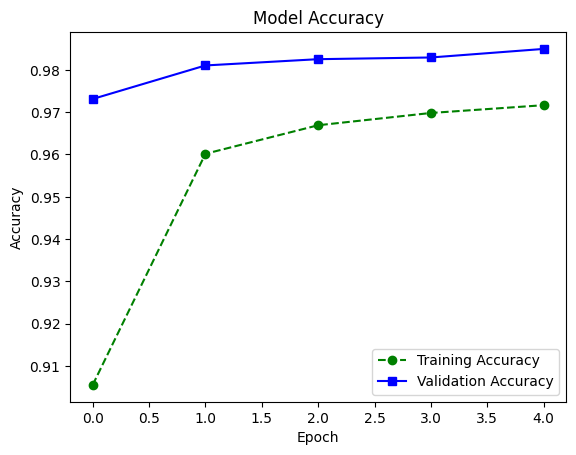

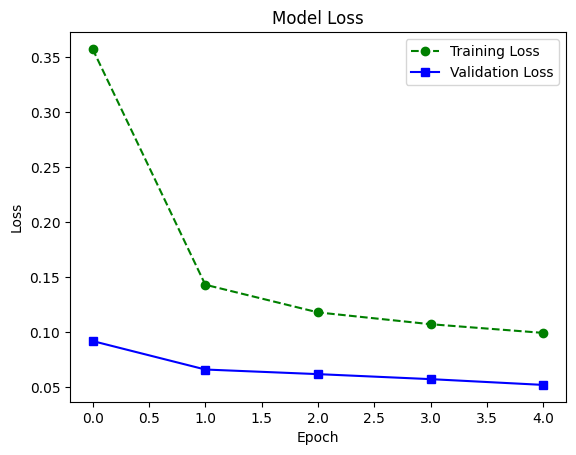

In [ ]:
import matplotlib.pyplot as plt


train_color = 'green'
val_color = 'blue'

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color=train_color, linestyle='dashed', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color=val_color, linestyle='solid', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


plt.plot(history.history['loss'], label='Training Loss', color=train_color, linestyle='dashed', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color=val_color, linestyle='solid', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [ ]:
from google.colab import files

files.download("/content/ocr_model_test.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>